In [1]:
#!cp -r /mnt/c/Users/david/trinity_algos/* ./new_dataset/paper_r_algos/

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from enum import Enum

In [3]:
class Mode(Enum):
    TriVMat = 1
    MorVMat = 2
    MorVTri = 3

In [4]:
def get_dataframe(tasks, datasets, results_dir, useAvg, compMode, TRs=[1], FRs=[1]):    
    dfs = []
    for task in tasks:
        for dataset in datasets:
            for TR in TRs:
                for FR in FRs:

                    logfile1 = None
                    logfile2 = None

                    if compMode == Mode.TriVMat:
                        logfile1 = results_dir + "/" + TEMPLATE % (task, dataset, TR, FR, "materialized")
                        logfile2 = results_dir + "/" + TEMPLATE % (task, dataset, TR, FR, "trinity")
                    if compMode == Mode.MorVMat:
                        logfile1 = results_dir + "/" + TEMPLATE % (task, dataset, TR, FR, "materialized")
                        logfile2 = results_dir + "/" + TEMPLATE % (task, dataset, TR, FR, "morpheusR")
                    if compMode == Mode.MorVTri:
                        logfile1 = results_dir + "/" + TEMPLATE % (task, dataset, TR, FR, "trinity")
                        logfile2 = results_dir + "/" + TEMPLATE % (task, dataset, TR, FR, "morpheusR")
                    
                    rawdata1 = np.loadtxt(logfile1)
                    rawdata2 = np.loadtxt(logfile2)
                        
                    warmeddata1 = rawdata1[-10:]
                    warmeddata2 = rawdata2[-10:]
                    
                    mean1 = np.mean(warmeddata1)
                    mean2 = np.mean(warmeddata2)
                    speedup = mean1 / mean2
                    
                    median1 = np.median(warmeddata1)
                    median2 = np.median(warmeddata2)
                    speedupMedian = median1 / median2

                    df = pd.DataFrame.from_dict([{
                        "TR" : TR,
                        "FR" : FR,
                        "baseTime" : mean1 if useAvg else median1,
                        "morpheusTime" : mean2 if useAvg else median2,
                        "speedUp" : speedup if useAvg else speedupMedian,
                        "task": task,
                        "dataset": dataset,
                        "numSamplesMat": len(rawdata1),
                        "numSamplesTrinity": len(rawdata2)
                    }])
                    dfs.append(df)
    full_exp_df = pd.concat(dfs, axis=0)
    return full_exp_df

In [5]:
def make_scatter_plot(df, banner, task, useMedian):

    def to_category(x):
        if x < 1:
            return 0
        elif x < 2:
            return 1
        elif x < 3:
            return 2
        elif x < 4:
            return 3
        elif x < 5:
            return 4
        else:
            return 5

    markers = ["o" ,"P" , "s" , "D", "h", "^"]
    colors = ['k','g','b','r', "orange", "gold"]
    labels = ["speedup<1", "1<speedup<2","2<speedup<3","3<speedup<4", "4<speedup<5","5>=speedup"]
    a1 = mlines.Line2D([], [], color='k', marker='o', markersize=10, label='Blue stars',linestyle="None")
    a2 = mlines.Line2D([], [], color='g', marker='P', markersize=10, label='Blue stars',linestyle="None")
    a3 = mlines.Line2D([], [], color='b', marker='s', markersize=10, label='Blue stars',linestyle="None")
    a4 = mlines.Line2D([], [], color='r', marker='D', markersize=10, label='Blue stars',linestyle="None")
    a5 = mlines.Line2D([], [], color='orange', marker='h', markersize=10, label='Blue stars',linestyle="None")
    a6 = mlines.Line2D([], [], color='gold', marker='^', markersize=10, label='Blue stars',linestyle="None")

    for _, row in df.iterrows():
        TR = row["TR"]
        FR = row["FR"]
        speed_up = row["speedUp"]

        index = to_category(speed_up)
        row_marker = markers[index]
        row_color = colors[index]

        plt.scatter(TR,FR,marker=row_marker, color=row_color)
    
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    plt.ylabel("Feature Ratio")
    plt.xlabel("Tuple Ratio")
    plt.legend([a1,a2,a3,a4,a5,a6], labels, loc='upper right', bbox_to_anchor=(1.025, -0.15), ncol=3)
    title = "Discretized Speedups of " + banner + " - " + task
    plt.title(title)
    suffix = "_mean.pdf" if useMedian else "_median.pdf"
    plt.savefig(title + suffix, bbox_inches='tight')
    plt.show()

In [6]:
def make_scatter_plot_comp(df, task):

    def to_category(x, minimum, increment):
        if x < minimum + 1*increment:
            return 0
        elif x < minimum + 2*increment:
            return 1
        elif x < minimum + 3*increment:
            return 2
        elif x < minimum + 4*increment:
            return 3
        elif x < minimum + 5*increment:
            return 4
        else:
            return 5

    markers = ["o" ,"P" , "s" , "D", "h", "^"]
    colors = ['k','g','b','r', "orange", "gold"]
    a1 = mlines.Line2D([], [], color='k', marker='o', markersize=10, label='Blue stars',linestyle="None")
    a2 = mlines.Line2D([], [], color='g', marker='P', markersize=10, label='Blue stars',linestyle="None")
    a3 = mlines.Line2D([], [], color='b', marker='s', markersize=10, label='Blue stars',linestyle="None")
    a4 = mlines.Line2D([], [], color='r', marker='D', markersize=10, label='Blue stars',linestyle="None")
    a5 = mlines.Line2D([], [], color='orange', marker='h', markersize=10, label='Blue stars',linestyle="None")
    a6 = mlines.Line2D([], [], color='gold', marker='^', markersize=10, label='Blue stars',linestyle="None")
    
    minimum = min(df["speedUp"])
    maximum = max(df["speedUp"])
    increment = (maximum-minimum) / 6
    
    labels = []
    for i in range(1,7):
        lower_bound = str(np.around(minimum + (i-1)*increment, 2))
        upper_bound = str(np.around(minimum + i*increment, 2))
        middle = "<Sp<"
        if i == 1:
            middle = "<=Sp<"
        if i == 6:
            middle = "<Sp<="
        label = lower_bound + middle + upper_bound
        labels.append(label)


    for _, row in df.iterrows():
        TR = row["TR"]
        FR = row["FR"]
        speed_up = row["speedUp"]

        index = to_category(speed_up, minimum, increment)
        row_marker = markers[index]
        row_color = colors[index]

        plt.scatter(TR,FR,marker=row_marker, color=row_color)
    
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    plt.ylabel("Feature Ratio")
    plt.xlabel("Tuple Ratio")
    plt.legend([a1,a4,a2,a5,a3,a6], labels, loc='upper right', bbox_to_anchor=(1.055, -0.15), ncol=3)
    title = "Discretized Speedups of MorpheusR over Trinity - " + task
    plt.title(title)
    plt.savefig(title, bbox_inches='tight')
    plt.show()
    

In [7]:
TEMPLATE = "%s_%s_TR=%d_FR=%d_%s.txt"
DATASETS = ["synth"]
RESULTS_DIR = "./new_dataset/paper_r_ops"
TRs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
FRs = [1,2,3,4,5]

In [8]:
def load_and_plot(TASK, DATASETS, RESULTS_DIR, TRs, FRs):
    TASKS = [TASK]
    df11 = get_dataframe(TASKS, DATASETS, RESULTS_DIR, True, Mode.TriVMat, TRs, FRs)
    df21 = get_dataframe(TASKS, DATASETS, RESULTS_DIR, False, Mode.TriVMat, TRs, FRs)
    df12 = get_dataframe(TASKS, DATASETS, RESULTS_DIR, True, Mode.MorVMat, TRs, FRs)
    df22 = get_dataframe(TASKS, DATASETS, RESULTS_DIR, False, Mode.MorVMat, TRs, FRs)
    df31 = get_dataframe(TASKS, DATASETS, RESULTS_DIR, True, Mode.MorVTri, TRs, FRs)
    df32 = get_dataframe(TASKS, DATASETS, RESULTS_DIR, False, Mode.MorVTri, TRs, FRs)

    make_scatter_plot(df11, "Trinity over Materialized", TASK, True)
    make_scatter_plot(df12, "Trinity over Materialized", TASK, False)
    make_scatter_plot(df21, "MorpheusR over Materialized", TASK, True)
    make_scatter_plot(df22, "MorpheusR over Materialized", TASK, False)
    make_scatter_plot(df31, "MorpheusR over Trinity", TASK, True)
    make_scatter_plot(df32, "MorpheusR over Trinity", TASK, False) 

leftMatrixMultiplication


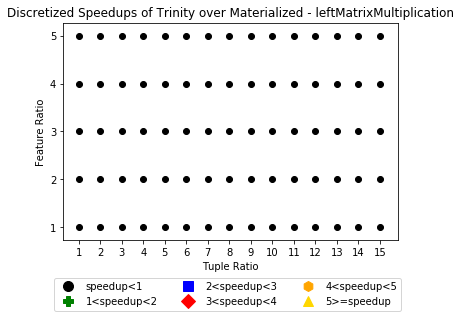

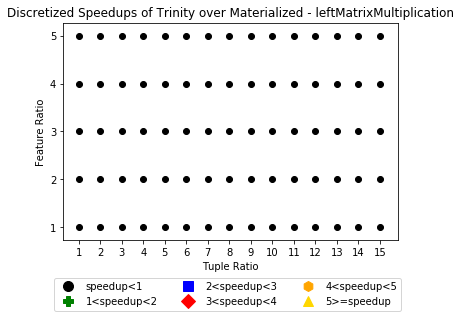

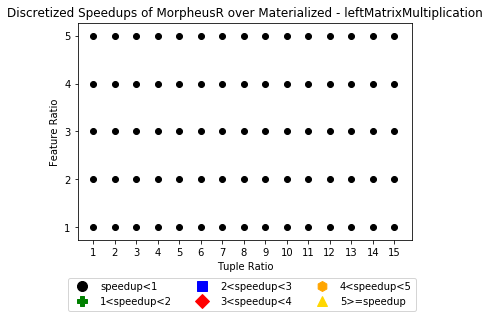

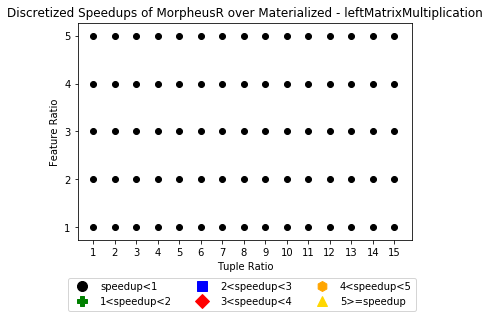

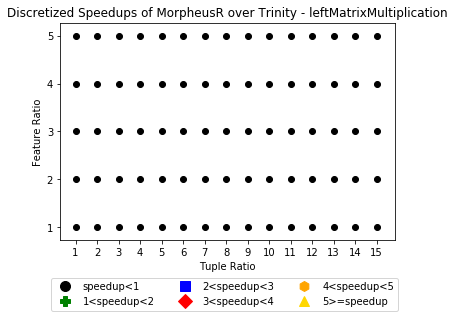

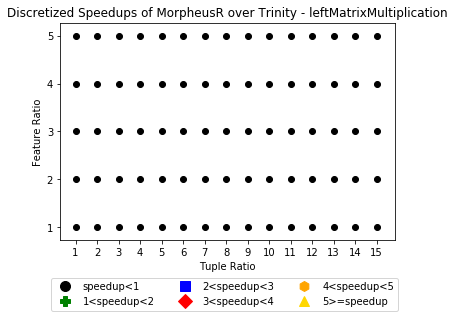

rightMatrixMultiplication


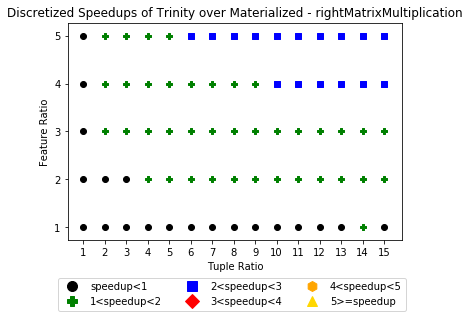

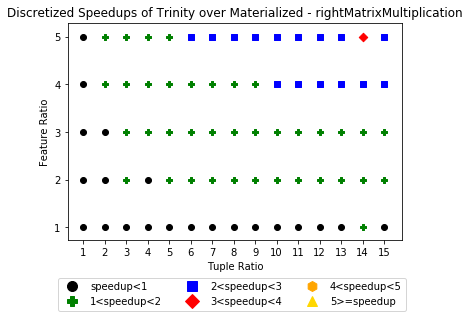

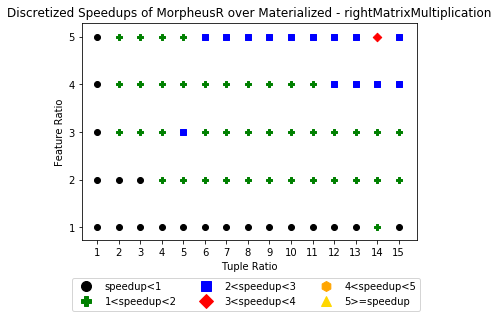

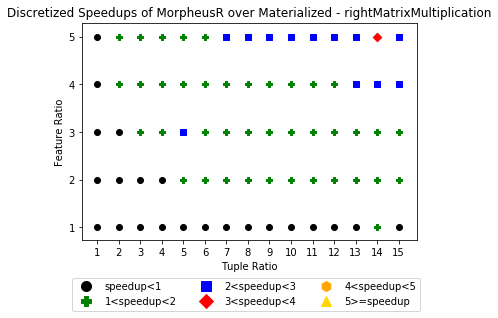

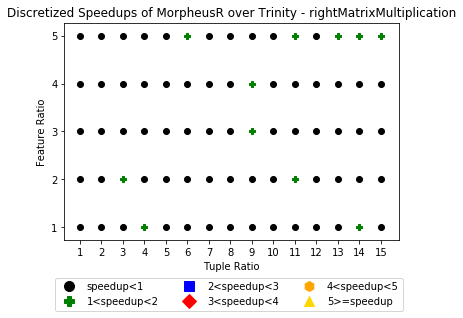

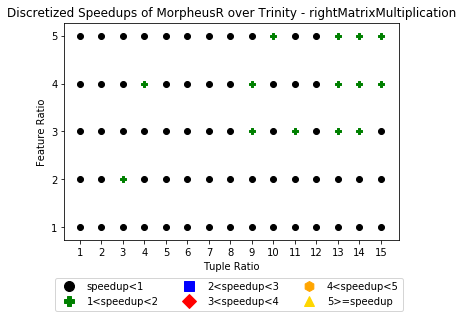

elementWiseSum


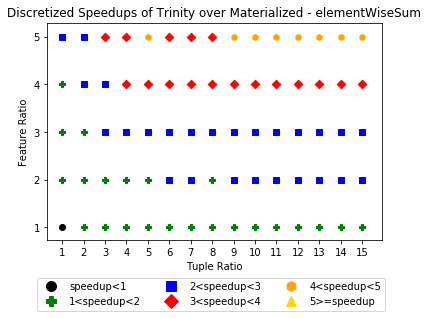

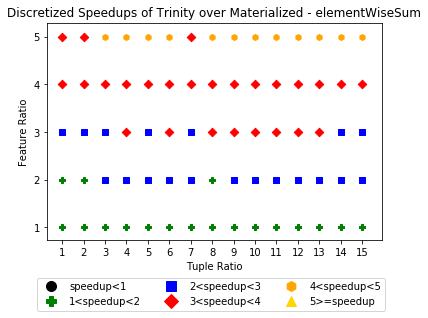

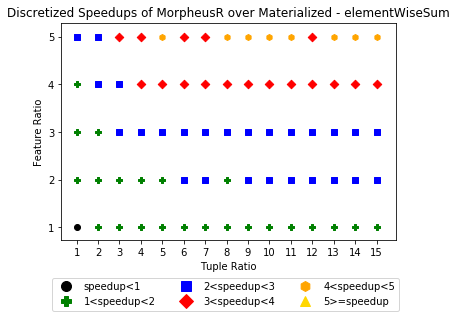

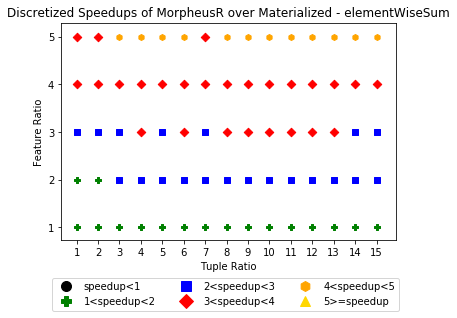

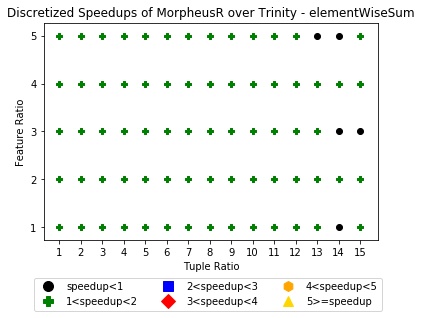

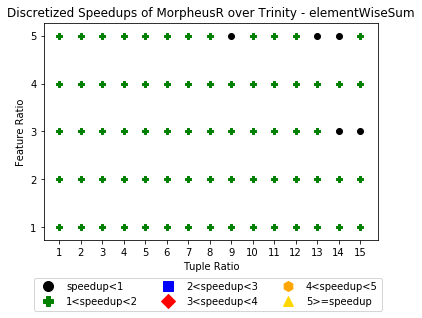

columnWiseSum


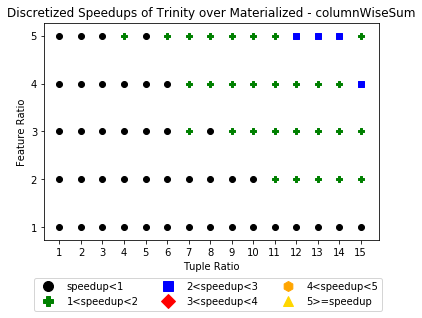

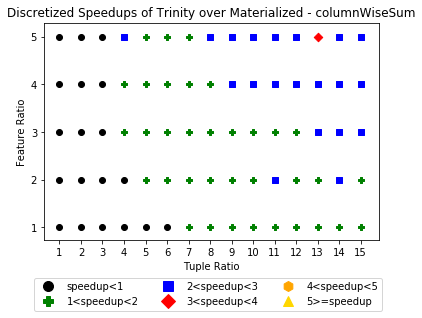

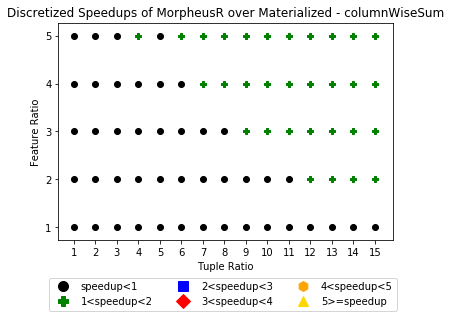

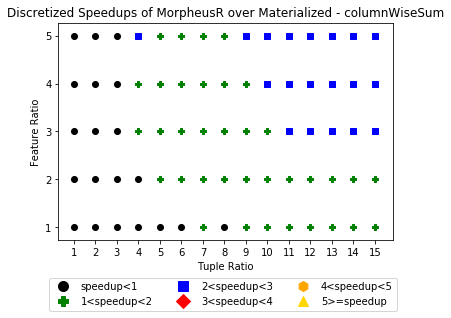

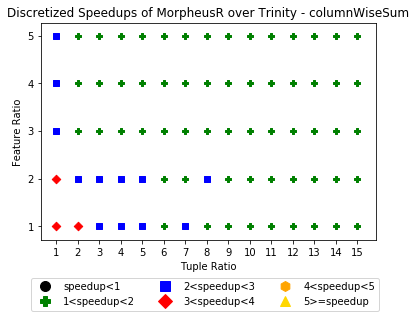

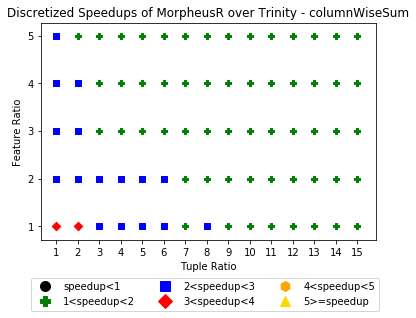

rowWiseSum


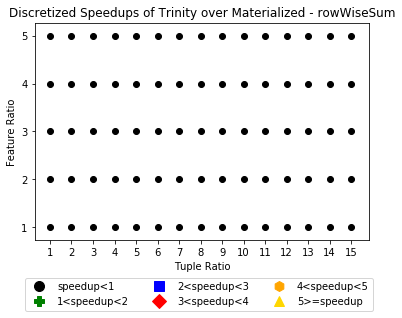

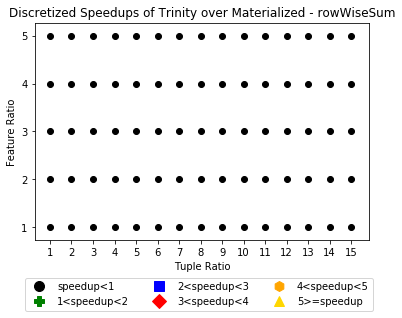

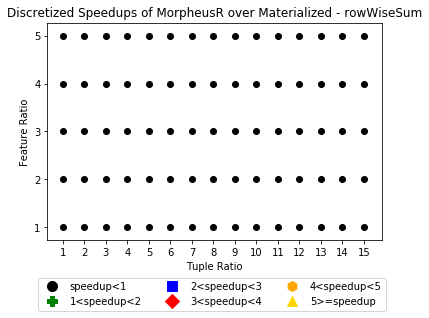

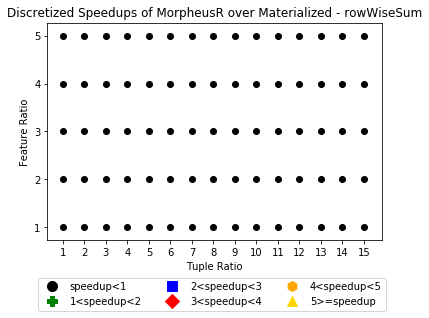

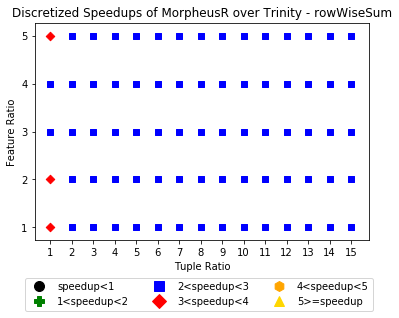

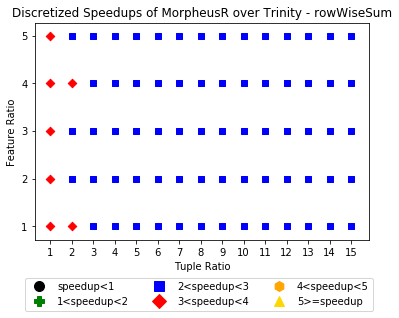

crossProduct


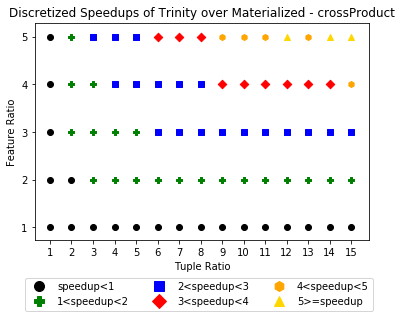

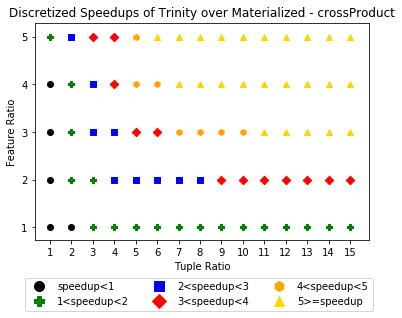

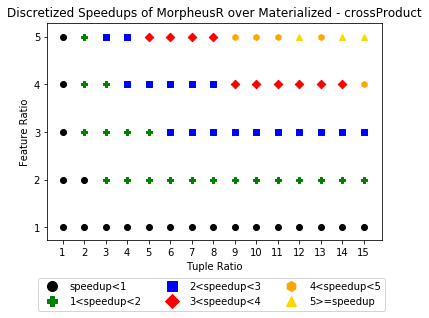

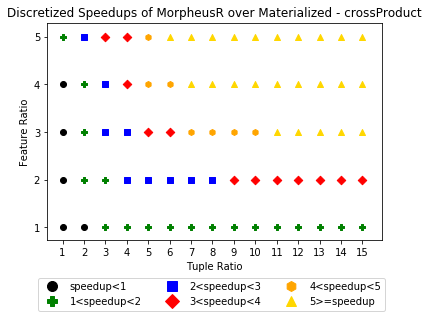

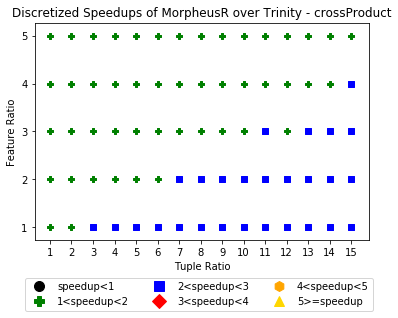

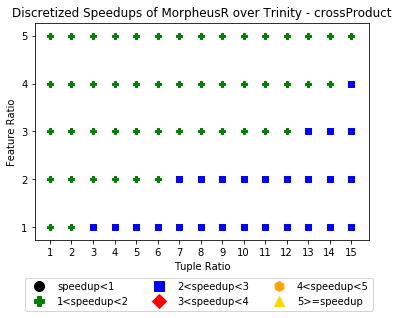

In [9]:
ops = [
    "leftMatrixMultiplication",
    "rightMatrixMultiplication", "elementWiseSum",
    "columnWiseSum", "rowWiseSum", "crossProduct"
]
for op in ops:
    print(op)
    load_and_plot(op, DATASETS, RESULTS_DIR, TRs, FRs)

In [10]:
def get_dataframe_algos_R(tasks, datasets, results_dir, TRs=[1], FRs=[1]):
    
    dfs =[]
    for task in tasks:
        for dataset in datasets:
            for TR in TRs:
                for FR in FRs:
                    if dataset == "synth_extended":
                        TR = 10
                        FR = 3
                    logfile1 = results_dir + "/" + TEMPLATE % (task, dataset, TR, FR, "materialized")
                    logfile2 = results_dir + "/" + TEMPLATE % (task, dataset, TR, FR, "trinity")
                    logfile3 = results_dir + "/" + TEMPLATE % (task, dataset, TR, FR, "morpheusR")
                    print(logfile1)
                    print(logfile2)
                    print(logfile3)

                    rawdata1 = np.loadtxt(logfile1)
                    rawdata2 = np.loadtxt(logfile2)
                    rawdata3 = np.loadtxt(logfile3)
                    
                    if(len(rawdata1) != len(rawdata2) or len(rawdata2) != len(rawdata3)):
                        exit(-1)
                    
                    warmeddata1 = rawdata1[-10:] / 1000
                    warmeddata2 = rawdata2[-10:] / 1000
                    warmeddata3 = rawdata3[-10:] / 1000
                    
                    mean1 = np.mean(warmeddata1)
                    mean2 = np.mean(warmeddata2)
                    mean3 = np.mean(warmeddata3)

                    speedup = mean1 / mean2
                    speedup2 = mean1 / mean3

                    df = pd.DataFrame.from_dict([{
                        "baseTime" : np.around(mean1, 2),
                        "trinityTime" : np.around(mean2, 2),
                        "morpheusRTime" : np.around(mean3, 2),
                        "meanSpeedUp" : np.around(speedup, 2),
                        "meanSpeedUp2" : np.around(speedup2, 2),
                        "task": task,
                        "dataset": dataset,
                        "STD1": np.around(np.std(warmeddata1),2),
                        "STD2": np.around(np.std(warmeddata2), 2),
                        "STD3": np.around(np.std(warmeddata3), 2)

                    }])
                    dfs.append(df)
    full_exp_df = pd.concat(dfs, axis=0)
    return full_exp_df

In [11]:
TEMPLATE = "%s_%s_TR=%d_FR=%d_%s.txt"
RESULTS_DIR = "./new_dataset/paper_r_algos" #"paper_r_algos_FINAL"
DATASETS = ["synth_extended","Movie", "Yelp", "Walmart", "Flights", "Expedia", "LastFM", "Books"]
TASKS = ["logisticRegression","linearRegression","kMeansClustering","GNMFClustering"]

In [12]:
df = get_dataframe_algos_R(TASKS, DATASETS, RESULTS_DIR)

./new_dataset/paper_r_algos/logisticRegression_synth_extended_TR=10_FR=3_materialized.txt
./new_dataset/paper_r_algos/logisticRegression_synth_extended_TR=10_FR=3_trinity.txt
./new_dataset/paper_r_algos/logisticRegression_synth_extended_TR=10_FR=3_morpheusR.txt
./new_dataset/paper_r_algos/logisticRegression_Movie_TR=1_FR=1_materialized.txt
./new_dataset/paper_r_algos/logisticRegression_Movie_TR=1_FR=1_trinity.txt
./new_dataset/paper_r_algos/logisticRegression_Movie_TR=1_FR=1_morpheusR.txt
./new_dataset/paper_r_algos/logisticRegression_Yelp_TR=1_FR=1_materialized.txt
./new_dataset/paper_r_algos/logisticRegression_Yelp_TR=1_FR=1_trinity.txt
./new_dataset/paper_r_algos/logisticRegression_Yelp_TR=1_FR=1_morpheusR.txt
./new_dataset/paper_r_algos/logisticRegression_Walmart_TR=1_FR=1_materialized.txt
./new_dataset/paper_r_algos/logisticRegression_Walmart_TR=1_FR=1_trinity.txt
./new_dataset/paper_r_algos/logisticRegression_Walmart_TR=1_FR=1_morpheusR.txt
./new_dataset/paper_r_algos/logisticReg

In [13]:
df

,baseTime,trinityTime,morpheusRTime,meanSpeedUp,meanSpeedUp2,task,dataset,STD1,STD2,STD3
0,213.79,41.84,49.88,5.11,4.29,logisticRegression,synth_extended,2.02,0.33,0.49
0,105.89,25.45,5.93,4.16,17.84,logisticRegression,Movie,1.72,0.34,0.24
0,32.54,7.29,2.01,4.47,16.19,logisticRegression,Yelp,0.90,0.14,0.32
0,26.37,17.51,3.68,1.51,7.17,logisticRegression,Walmart,0.70,0.20,0.14
0,4.20,5.13,4.91,0.82,0.86,logisticRegression,Flights,0.21,0.18,0.29
0,115.74,49.86,48.96,2.32,2.36,logisticRegression,Expedia,2.21,1.33,1.10
0,18.00,10.56,2.35,1.70,7.64,logisticRegression,LastFM,0.41,0.15,0.10
0,9.83,8.77,2.22,1.12,4.43,logisticRegression,Books,0.14,0.16,0.13
0,224.95,32.63,57.89,6.89,3.89,linearRegression,synth_extended,3.91,0.34,0.54
0,106.01,16.85,4.19,6.29,25.28,linearRegression,Movie,2.18,0.24,0.23


In [14]:
def create_table(df):
    datasets = np.unique(df["dataset"])
    for dataset in DATASETS:
        dset_id = dataset[0]
        row = [dset_id]
        for task in ["kMeansClustering", "GNMFClustering"]:
            dfs = df[(df["dataset"] == dataset) & (df["task"] == task)]
            row = row + [dfs["baseTime"][0], dfs["meanSpeedUp"][0], dfs["meanSpeedUp2"][0]]
        print(' & '.join(map(str,row)) + "\\\\")
        print("\hline")
 

In [15]:
create_table(df)

s & 985.34 & 3.59 & 1.76 & 135.03 & 0.85 & 0.47\\
\hline
M & 241.76 & 2.71 & 4.71 & 64.99 & 0.87 & 0.73\\
\hline
Y & 74.12 & 2.79 & 3.04 & 16.14 & 0.77 & 0.68\\
\hline
W & 50.31 & 0.65 & 2.5 & 21.78 & 0.45 & 0.6\\
\hline
F & 9.79 & 0.58 & 0.37 & 5.03 & 0.47 & 0.31\\
\hline
E & 261.86 & 1.47 & 0.88 & 71.51 & 0.58 & 0.39\\
\hline
L & 40.75 & 1.11 & 1.44 & 19.79 & 0.67 & 0.59\\
\hline
B & 27.24 & 0.84 & 0.8 & 16.22 & 0.63 & 0.6\\
\hline


In [17]:
def get_dataframe_algos_JS(tasks, datasets, results_dir, TRs=[1], FRs=[1]):
    
    dfs =[]
    for task in tasks:
        for dataset in datasets:
            for TR in TRs:
                for FR in FRs:
                    logfile1 = results_dir + "/" + TEMPLATE % (task, TR, FR, "materialized")
                    logfile2 = results_dir + "/" + TEMPLATE % (task, TR, FR, "trinity")

                    rawdata1 = np.loadtxt(logfile1)
                    rawdata2 = np.loadtxt(logfile2)
                    
                    end = min(len(rawdata1), len(rawdata2))
                    
                    warmeddata1 = rawdata1[-10:]
                    warmeddata2 = rawdata2[-10:]
                    
                    mean1 = np.mean(warmeddata1)
                    mean2 = np.mean(warmeddata2)
                    speedup = mean1 / mean2
                    
                    median1 = np.median(warmeddata1)
                    median2 = np.median(warmeddata2)
                    speedupMedian = median1 / median2
                    
                    matSTD = np.std(warmeddata1)
                    normSTD = np.std(warmeddata2)


                    df = pd.DataFrame.from_dict([{
                        "TR" : TR,
                        "FR" : FR,
                        "baseTime" : mean1,
                        "morpheusTime" : mean2,
                        "meanSpeedUp" : speedup,
                        "meadianSpeedUp": speedupMedian,
                        "task": task,
                        "dataset": dataset,
                        "numSamplesMat": len(rawdata1),
                        "numSamplesTrinity": len(rawdata2),
                        "matSTD": matSTD,
                        "normSTD": normSTD
                    }])
                    dfs.append(df)
    full_exp_df = pd.concat(dfs, axis=0)
    return full_exp_df

In [18]:
TEMPLATE = "%s_TR=%d_FR=%d_%s.txt"
RESULTS_DIR = "./new_dataset/paper_js_algos"
DATASETS = ["synth"]
TRs = [10]
FRs = [1,2,3,4,5]
TASKS = ["logisticRegression"]

In [19]:
df = get_dataframe_algos_JS(TASKS, DATASETS, RESULTS_DIR, TRs, FRs)
df = df.rename(columns={"meadianSpeedUp" : "medianSpeedUp"})
df

,TR,FR,baseTime,morpheusTime,meanSpeedUp,medianSpeedUp,task,dataset,numSamplesMat,numSamplesTrinity,matSTD,normSTD
0,10,1,655.305847,594.066767,1.103085,1.101227,logisticRegression,synth,25,25,9.080691,12.817610
0,10,2,980.494990,643.975837,1.522565,1.527452,logisticRegression,synth,25,25,13.549051,12.216929
0,10,3,1271.514636,673.981900,1.886571,1.883400,logisticRegression,synth,25,25,17.630999,13.951662
0,10,4,2274.363680,720.558547,3.156390,3.147119,logisticRegression,synth,25,25,15.573376,7.613143
0,10,5,1944.110722,787.953207,2.467292,2.464761,logisticRegression,synth,25,25,28.891793,9.164629


In [20]:
def create_table(df):
    datasets = ["synth"]
    for dataset in datasets:
        for task in TASKS:
            for TR in TRs:
                for FR in FRs:
                    row = []
                    dfs = df[(df["dataset"] == dataset) & (df["task"] == task) & (df["TR"] == TR) & (df["FR"] == FR)]
                    row = row + [FR, dfs["baseTime"][0], dfs["meanSpeedUp"][0],dfs["matSTD"][0], dfs["normSTD"][0]]
                    print(' & '.join(map(str, map(lambda x: np.around(x,2), row))) + "\\\\")
                    print("\hline")

In [21]:
create_table(df)

1 & 655.31 & 1.1 & 9.08 & 12.82\\
\hline
2 & 980.49 & 1.52 & 13.55 & 12.22\\
\hline
3 & 1271.51 & 1.89 & 17.63 & 13.95\\
\hline
4 & 2274.36 & 3.16 & 15.57 & 7.61\\
\hline
5 & 1944.11 & 2.47 & 28.89 & 9.16\\
\hline


In [22]:
def get_dataframe_algo_py(tasks, datasets, results_dir, TRs=[1], FRs=[1]):
    
    dfs =[]
    for task in tasks:
        for dataset in datasets:
            for TR in TRs:
                for FR in FRs:
                    logfile1 = results_dir + "/" + TEMPLATE % (task, dataset, TR, FR, "materialized")
                    logfile2 = results_dir + "/" + TEMPLATE % (task, dataset, TR, FR, "trinity")

                    rawdata1 = np.loadtxt(logfile1)
                    rawdata2 = np.loadtxt(logfile2)
                    
                    end = min(len(rawdata1), len(rawdata2))
                    
                    warmeddata1 = rawdata1[-10:] / 1000
                    warmeddata2 = rawdata2[-10:] / 1000
                    
                    mean1 = np.mean(warmeddata1)
                    mean2 = np.mean(warmeddata2)
                    speedup = mean1 / mean2
                    
                    median1 = np.median(warmeddata1)
                    median2 = np.median(warmeddata2)
                    speedupMedian = median1 / median2

                    
                    matSTD = np.std(warmeddata1)
                    normSTD = np.std(warmeddata2)
                    df = pd.DataFrame.from_dict([{
                        "TR" : TR,
                        "FR" : FR,
                        "baseTime" : mean1,
                        "morpheusTime" : mean2,
                        "meanSpeedUp" : speedup,
                        "meadianSpeedUp": speedupMedian,
                        "task": task,
                        "dataset": dataset,
                        "numSamplesMat": len(rawdata1),
                        "numSamplesTrinity": len(rawdata2),
                        "matSTD": matSTD,
                        "normSTD": normSTD
                    }])
                    dfs.append(df)
    full_exp_df = pd.concat(dfs, axis=0)
    return full_exp_df

In [23]:
TEMPLATE = "%s_%s_TR=%d_FR=%d_%s.txt"
RESULTS_DIR = "./new_dataset/paper_py_algos"
DATASETS = ["synth"]
TRs = [10]
FRs = [1,2,3,4,5]
TASKS = ["logisticRegression"]

In [24]:
def create_table(df):
    datasets = ["synth"]
    for dataset in datasets:
        for task in TASKS:
            for TR in TRs:
                for FR in FRs:
                    row = []
                    dfs = df[(df["dataset"] == dataset) & (df["task"] == task) & (df["TR"] == TR) & (df["FR"] == FR)]
                    row = row + [FR, dfs["baseTime"][0], dfs["meanSpeedUp"][0],dfs["matSTD"][0], dfs["normSTD"][0]]
                    print(' & '.join(map(str, map(lambda x: np.around(x,2), row))) + "\\\\")
                    print("\hline")

In [25]:
df = get_dataframe_algo_py(TASKS, DATASETS, RESULTS_DIR, TRs, FRs)
df

,TR,FR,baseTime,morpheusTime,meanSpeedUp,meadianSpeedUp,task,dataset,numSamplesMat,numSamplesTrinity,matSTD,normSTD
0,10,1,42.0765,42.2272,0.996431,0.994069,logisticRegression,synth,25,25,0.851955,0.985198
0,10,2,58.0445,59.4986,0.975561,0.981014,logisticRegression,synth,23,23,0.911717,1.025313
0,10,3,77.2263,77.3672,0.998179,0.978448,logisticRegression,synth,17,17,6.827430,3.119113
0,10,4,90.3710,91.5498,0.987124,0.988573,logisticRegression,synth,13,13,2.939274,4.273797
0,10,5,107.8725,104.3976,1.033285,1.005339,logisticRegression,synth,11,11,8.443954,4.055105


In [26]:
create_table(df)

1 & 42.08 & 1.0 & 0.85 & 0.99\\
\hline
2 & 58.04 & 0.98 & 0.91 & 1.03\\
\hline
3 & 77.23 & 1.0 & 6.83 & 3.12\\
\hline
4 & 90.37 & 0.99 & 2.94 & 4.27\\
\hline
5 & 107.87 & 1.03 & 8.44 & 4.06\\
\hline
